In [7]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [9]:
df = pd.read_csv(os.getcwd()+r"\Data Files\Corpus_MRO.csv", encoding = 'unicode_escape')

In [10]:
df.head()

,spend_group,spend_cat_sim_l1_nestec,spend_cat_sim_l2_nestec,spend_cat_sim_l3_nestec,material_group_master_data,material_group_master_data_desc,material,material_desc,material_descr_from_po,purchasing_org,...,material_type,material_type_desc,base_unit,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2
0,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,** Carbagas/Kohlendioxyd CO2 Flüssiggas,CH10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5012160,Energy-CO2,0010/001718102,CO2,"10,400.42 CHF","10,400.42",24 Industrial Gases
1,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,***UMO ALQUILER UNIDAD CRIOGENICA,ES10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0045/794241001,Gastos comunes fábri,"3,574.48 EUR","3,972.83",24 Industrial Gases
2,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,"**19 - CARBON DIOXIDE, COMPLIANCE TRANSP",US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0076/013893010,Site Supply Chain,"$15,822.53","15,657.73",24 Industrial Gases
3,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**Bulk CO2 Gas,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5014020,Eng. 3rd Part Serv,0042/548919003,TECHNICAL OFFICE,"$1,726.96","1,698.81",24 Industrial Gases
4,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**CO2 - BULK CARBON DIOXIDE,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0042/587817201,REFRIGERATION,"$8,786.90","8,777.23",24 Industrial Gases


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [12]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 10

In [13]:
df.label_l2.value_counts()

24 MRO Services                   3566
24 Workshop Equipment&Supplies    1121
24 Industrial Gases                669
Name: label_l2, dtype: int64

In [14]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [15]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [16]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 3427 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 857 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 1072 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [18]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [19]:
all_col = list(X_train.columns)

In [20]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [21]:
from keras.utils import to_categorical

# LSTM Model 

In [22]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 20)            116640    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 26, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 165,343
Trainable params: 165,343
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [24]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9997
Valid Accuracy:  0.9918
Testing Accuracy:  0.9963


In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

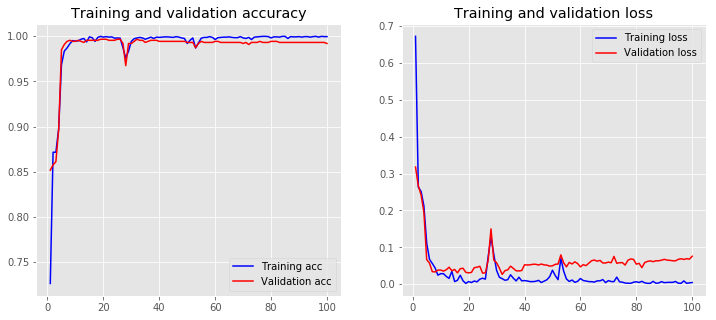

In [26]:
plot_history(history)

# Hyperparameter Tuning

In [27]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# # model.add(layers.Flatten())
# # model.add(layers.Dense(10, activation='relu'))
# # model.add(layers.Dense(3, activation='sigmoid'))
# model.add(layers.SpatialDropout1D(0.2))
# model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [28]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_lstm=100, dropout = 0.2, recurrent_dropout=0.2):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(n_dense, activation=activation))
#     model.add(layers.Dense(3, activation='sigmoid'))

    model.add(layers.SpatialDropout1D(dropout))
    model.add(layers.LSTM(n_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [29]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [25, 32, 40], 
          'epochs': [10,12,15],
          'learning_rate': [0.01, 0.001, 0.0005],
          'embedding_dim' : [10,15,20,25,30],
          'n_lstm' : [50,70,100,120],
          'dropout' : [0.1,0.15,0.2,0.25,0.3], 
          'recurrent_dropout' : [0.1,0.15,0.2,0.25,0.3]
         }

In [30]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [31]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [32]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.6240 - accuracy: 0.7316
Epoch 2/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2672 - accuracy: 0.8656
Epoch 3/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2591 - accuracy: 0.8792
Epoch 4/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.1861 - accuracy: 0.9295
Epoch 5/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.0949 - accuracy: 0.9729
Epoch 6/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.0761 - accuracy: 0.9764
Epoch 7/10
2284/2284 [==============================] - 4s 2ms/step - loss: 0.0633 - accuracy: 0.9829
Epoch 8/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.0466 - accuracy: 0.9873
Epoch 9/10
2284/2284 [==============================] - 3s 1ms/step - loss: 0.0457 - accuracy: 0.9882
Epoch 10/10
2284/2284 [==============================] - 1s 31

2284/2284 [==============================] - 2s 892us/step - loss: 0.1525 - accuracy: 0.9457
Epoch 8/10
2284/2284 [==============================] - 2s 883us/step - loss: 0.0812 - accuracy: 0.9768
Epoch 9/10
2284/2284 [==============================] - 2s 856us/step - loss: 0.0654 - accuracy: 0.9860
Epoch 10/10
2284/2284 [==============================] - 0s 207us/step
Epoch 1/10
2285/2285 [==============================] - 3s 1ms/step - loss: 0.7169 - accuracy: 0.6967
Epoch 2/10
2285/2285 [==============================] - 2s 983us/step - loss: 0.2601 - accuracy: 0.8691
Epoch 3/10
2285/2285 [==============================] - 2s 816us/step - loss: 0.2392 - accuracy: 0.8705
Epoch 4/10
2285/2285 [==============================] - 2s 811us/step - loss: 0.2451 - accuracy: 0.8753
Epoch 5/10
2285/2285 [==============================] - 2s 822us/step - loss: 0.2309 - accuracy: 0.8740
Epoch 6/10
2285/2285 [==============================] - 2s 822us/step - loss: 0.2165 - accuracy: 0.8893
Epoch 

2284/2284 [==============================] - 2s 953us/step - loss: 0.2355 - accuracy: 0.8752
Epoch 5/15
2284/2284 [==============================] - 2s 884us/step - loss: 0.2311 - accuracy: 0.8748
Epoch 6/15
2284/2284 [==============================] - 2s 930us/step - loss: 0.2172 - accuracy: 0.8853
Epoch 7/15
2284/2284 [==============================] - 2s 888us/step - loss: 0.1601 - accuracy: 0.9418
Epoch 8/15
2284/2284 [==============================] - 2s 865us/step - loss: 0.0956 - accuracy: 0.9729
Epoch 9/15
2284/2284 [==============================] - 2s 894us/step - loss: 0.0411 - accuracy: 0.9895
Epoch 10/15
2284/2284 [==============================] - 2s 886us/step - loss: 0.0439 - accuracy: 0.9912
Epoch 11/15
2284/2284 [==============================] - 2s 905us/step - loss: 0.0257 - accuracy: 0.9934
Epoch 12/15
2284/2284 [==============================] - 2s 871us/step - loss: 0.0246 - accuracy: 0.9930
Epoch 13/15
2284/2284 [==============================] - 2s 975us/step -

2284/2284 [==============================] - 3s 1ms/step - loss: 0.8632 - accuracy: 0.6598
Epoch 2/15
2284/2284 [==============================] - 2s 816us/step - loss: 0.2977 - accuracy: 0.8516
Epoch 3/15
2284/2284 [==============================] - 2s 869us/step - loss: 0.2420 - accuracy: 0.8735
Epoch 4/15
2284/2284 [==============================] - 2s 857us/step - loss: 0.2326 - accuracy: 0.8743
Epoch 5/15
2284/2284 [==============================] - 2s 850us/step - loss: 0.2403 - accuracy: 0.8752
Epoch 6/15
2284/2284 [==============================] - 2s 853us/step - loss: 0.1964 - accuracy: 0.9098
Epoch 7/15
2284/2284 [==============================] - 2s 858us/step - loss: 0.1332 - accuracy: 0.9562
Epoch 8/15
2284/2284 [==============================] - 2s 846us/step - loss: 0.0845 - accuracy: 0.9755
Epoch 9/15
2284/2284 [==============================] - 2s 864us/step - loss: 0.0486 - accuracy: 0.9882
Epoch 10/15
2284/2284 [==============================] - 2s 828us/step - loss

2285/2285 [==============================] - 2s 732us/step - loss: 0.2306 - accuracy: 0.8757
Epoch 10/10
2285/2285 [==============================] - 0s 149us/step
Epoch 1/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.8103 - accuracy: 0.6708
Epoch 2/12
2284/2284 [==============================] - 2s 731us/step - loss: 0.2762 - accuracy: 0.86120s - loss: 0.2814 - accura
Epoch 3/12
2284/2284 [==============================] - 2s 776us/step - loss: 0.2486 - accuracy: 0.8704
Epoch 4/12
2284/2284 [==============================] - 2s 785us/step - loss: 0.2429 - accuracy: 0.8735
Epoch 5/12
2284/2284 [==============================] - 2s 815us/step - loss: 0.2352 - accuracy: 0.8739
Epoch 6/12
2284/2284 [==============================] - 2s 791us/step - loss: 0.2281 - accuracy: 0.8757
Epoch 7/12
2284/2284 [==============================] - 2s 791us/step - loss: 0.2298 - accuracy: 0.8827
Epoch 8/12
2284/2284 [==============================] - 2s 786us/step - loss: 0.2146

2285/2285 [==============================] - 3s 1ms/step - loss: 0.0607 - accuracy: 0.9895
Epoch 12/15
2285/2285 [==============================] - 3s 1ms/step - loss: 0.0175 - accuracy: 0.9978
Epoch 13/15
2285/2285 [==============================] - 2s 1ms/step - loss: 0.0223 - accuracy: 0.9956
Epoch 14/15
2285/2285 [==============================] - 2s 1ms/step - loss: 0.0156 - accuracy: 0.9974
Epoch 15/15
2285/2285 [==============================] - 1s 256us/step
Epoch 1/15
2285/2285 [==============================] - 3s 1ms/step - loss: 0.6783 - accuracy: 0.7103
Epoch 2/15
2285/2285 [==============================] - 2s 1ms/step - loss: 0.2819 - accuracy: 0.8665
Epoch 3/15
2285/2285 [==============================] - 3s 1ms/step - loss: 0.2467 - accuracy: 0.8731
Epoch 4/15
2285/2285 [==============================] - 2s 1ms/step - loss: 0.1969 - accuracy: 0.9002
Epoch 5/15
2285/2285 [==============================] - 3s 1ms/step - loss: 0.1152 - accuracy: 0.9663
Epoch 6/15
2285/228

2284/2284 [==============================] - 4s 2ms/step - loss: 0.7138 - accuracy: 0.6918
Epoch 2/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2709 - accuracy: 0.8691
Epoch 3/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2465 - accuracy: 0.8748
Epoch 4/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2450 - accuracy: 0.8722
Epoch 5/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2651 - accuracy: 0.8735
Epoch 6/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2339 - accuracy: 0.8805
Epoch 7/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.2069 - accuracy: 0.9129
Epoch 8/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.1484 - accuracy: 0.9496
Epoch 9/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.0840 - accuracy: 0.9768
Epoch 10/12
2284/2284 [==============================] - 3s 1ms/step - loss: 0.1519 - accurac

In [33]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.06228057561300397 and Best Params:  {'recurrent_dropout': 0.2, 'n_lstm': 50, 'learning_rate': 0.01, 'epochs': 15, 'embedding_dim': 30, 'dropout': 0.15, 'batch_size': 40, 'activation': 'relu'}


## Fit Best Model

In [34]:
model = create_model(learning_rate=0.01, activation='relu', embedding_dim=30, n_lstm=50, dropout = 0.15, recurrent_dropout=0.2)

In [35]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=40)

In [36]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9994
Valid Accuracy:  0.9965
Testing Accuracy:  0.9972


In [37]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

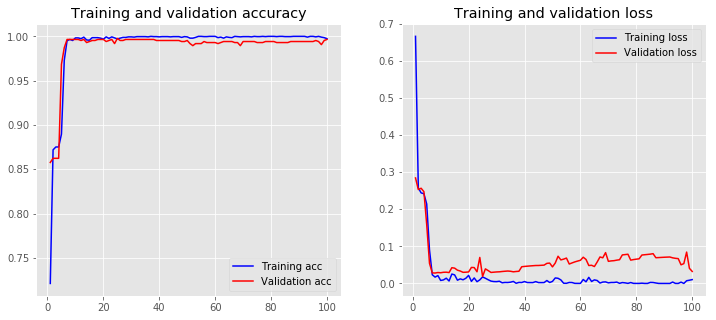

In [38]:
plot_history(history)

# Model Evaluation: Test Data

In [39]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9972015023231506


Confusion matrix, without normalization


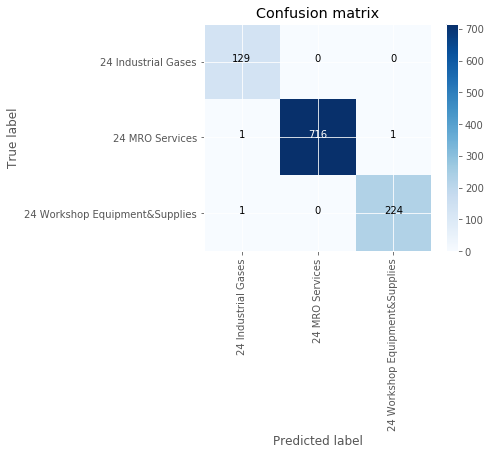

In [40]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [41]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9943337585363619

In [42]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,0.984733,1.000000,0.992308,129
1,24 MRO Services,1.000000,0.997214,0.998605,718
2,24 Workshop Equipment&Supplies,0.995556,0.995556,0.995556,225


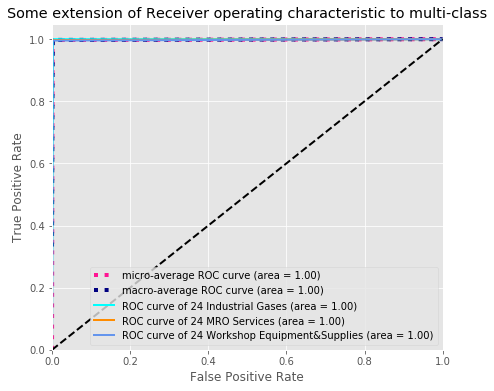

In [43]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [44]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

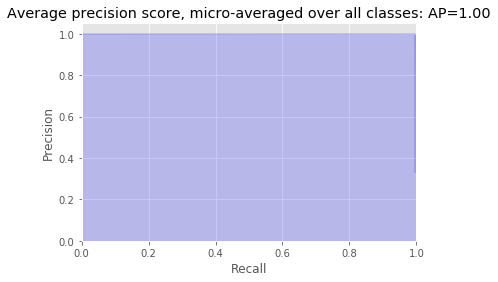

In [45]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

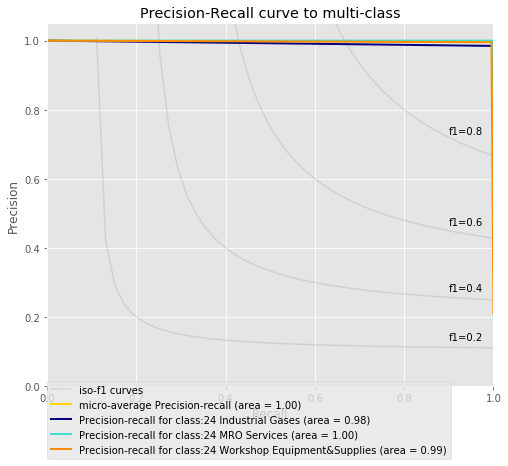

In [46]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()